In [28]:
%run imports.ipynb
# make sure that the file imports.ipynb is in the same folder as this notebook

### Making file for period ratios of planets around small cool stars


In [29]:
workingTableExoplanets = pandas.read_pickle("../data/triples_MR.pkl")

planetstodrop = []

for index, row in workingTableExoplanets.iterrows():
    if (abs(workingTableExoplanets.at[index,"period_error_min-1"]) + workingTableExoplanets.at[index,"period_error_max-1"])/workingTableExoplanets.at[index,"period-1"] >= 2.0:
        planetstodrop.append(index)
    if (abs(workingTableExoplanets.at[index,"period_error_min-2"]) + workingTableExoplanets.at[index,"period_error_max-2"])/workingTableExoplanets.at[index,"period-2"] >= 2.0:
        planetstodrop.append(index)
    if (abs(workingTableExoplanets.at[index,"period_error_min-3"]) + workingTableExoplanets.at[index,"period_error_max-3"])/workingTableExoplanets.at[index,"period-2"] >= 2.0:
        planetstodrop.append(index)
# print(len(planetstodrop))

workingTableExoplanets = workingTableExoplanets.drop(index=planetstodrop)

workingTableExoplanets = workingTableExoplanets.query("`period-1`.notna() & `period-2`.notna()& `period-3`.notna()")
workingTableExoplanets = workingTableExoplanets.query("`period_error_min-1`.notna() & `period_error_min-2`.notna()& `period_error_min-3`.notna() & `period_error_max-1`.notna() & `period_error_max-2`.notna()& `period_error_max-3`.notna()")

workingTableExoplanets["periodratio-1"] = workingTableExoplanets["period-2"] / workingTableExoplanets["period-1"]
period_1 = workingTableExoplanets["periodratio-1"]
workingTableExoplanets['periodratio_error_min-1'] = (workingTableExoplanets["period_error_min-1"]/workingTableExoplanets["period-1"] + workingTableExoplanets["period_error_min-2"]/workingTableExoplanets["period-2"]) * periods_ratio1# assigned to a column
workingTableExoplanets['periodratio_error_max-1'] = (workingTableExoplanets["period_error_max-1"]/workingTableExoplanets["period-1"] + workingTableExoplanets["period_error_max-2"]/workingTableExoplanets["period-2"]) * periods_ratio1
workingTableExoplanets["periodratio-2"] = workingTableExoplanets["period-3"] / workingTableExoplanets["period-2"]
period_2 = workingTableExoplanets["periodratio-2"]
workingTableExoplanets['periodratio_error_min-2'] = (workingTableExoplanets["period_error_min-2"]/workingTableExoplanets["period-2"] + workingTableExoplanets["period_error_min-3"]/workingTableExoplanets["period-3"]) * periods_ratio2 # assigned to a column
workingTableExoplanets['periodratio_error_max-2'] = (workingTableExoplanets["period_error_max-2"]/workingTableExoplanets["period-2"] + workingTableExoplanets["period_error_max-3"]/workingTableExoplanets["period-2"])*periods_ratio2


tablePlan = workingTableExoplanets.query("`star_radius` <1.")
tablePlan = tablePlan.query("`star_mass` <1.")
tablePlan = tablePlan.query("`star_teff` <5777.")


tablePlan = tablePlan.sort_values("star_mass")
tablePlan =tablePlan.head(40)
## uncomment if you want to display the sub-sample
# with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(tablePlan)
tablePlan.to_pickle("../data/lowMRT_per.pkl")


### Calculating the Pearson correlation coefficients for certain stellar parameter range and performing the bootsrap test by choosing random 40 pairs from the entire sample

This cell is making use of .pkl files saved after running MRD_adjacent_planets.py which contain an unusually correlated subsample. Such a file will look like that: "./data/80_0.8793810742432698_star_age_mass.pkl", and the first part "80" indicates at which x this subsample starts within the main sample, and numbers after underscore like "0.879..." will indicate the R-value of the subsample

Upper side of the line, planets: 18 , part: 0.45
Lower side of the line, planets: 22 , part: 0.55
On the line, planets: 0
Pearson Correlation Coefficient for raw data:  0.04378264956897132 and a P-value of: 0.7885040412901969
-0.10319607645615052 -0.0


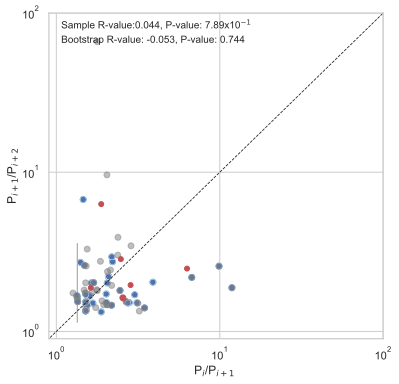

In [30]:
# load file either for small cool star as stated there or one of .pkl resulting from running MRD_adjacent_planets.py.

tableEX1 = pandas.read_pickle("../data/lowMRT_per.pkl")
## uncomment if you want to display the sub-sample
# with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(tableEX1)

period_1 = tableEX1["periodratio-1"]
period_2 = tableEX1["periodratio-2"]
star_age = tableEX1["star_age"]
star_teff = tableEX1["star_teff"]
star_mass = tableEX1["star_mass"]
star_radius = tableEX1["star_radius"]
star_metallicity = tableEX1["star_metallicity"]
star_rotp = tableEX1["st_rotp"]

resultsExoplanetsm2 = tableEX1.query("`periodratio-2` > `periodratio-1`")
resultsExoplanetsm1 = tableEX1.query("`periodratio-2` < `periodratio-1`")
resultsExoplanetsmeq = tableEX1.query("`periodratio-2` == `periodratio-1`")

print(f'Upper side of the line, planets:', len(resultsExoplanetsm2), ', part:', numpy.round(len(resultsExoplanetsm2)/ len(tableEX1), 3))
print(f'Lower side of the line, planets:', len(resultsExoplanetsm1), ', part:', numpy.round(len(resultsExoplanetsm1)/ len(tableEX1), 3))
print(f'On the line, planets:', len(resultsExoplanetsmeq))

pearson_coef, p_value = stats.pearsonr(period_1, period_2) #define the columns to perform calculations on
print("Pearson Correlation Coefficient for raw data: ", pearson_coef, "and a P-value of:", p_value) # Results

seaborn.set_theme(style="whitegrid")
plt.rcParams['figure.figsize']=(6,6)
cmap = seaborn.cubehelix_palette(rot=-.3, as_cmap=True)
g = seaborn.scatterplot(
    x=period_1, y=period_2,
    palette=cmap, legend=False
)
g.set(xscale="log", yscale="log")

g.set(ylim=(0.9, 100))
g.set(xlim=(0.9, 100))
x = numpy.linspace(0.1, 100, 200)
y = x
plt.plot(x, y, linewidth=0.8, linestyle='--', color='k')
xerr = numpy.nan_to_num(tableEX1[["periodratio_error_min-1", "periodratio_error_max-1"]].to_numpy().T, posinf=0.)
yerr = numpy.nan_to_num(tableEX1[["periodratio_error_min-2", "periodratio_error_max-2"]].to_numpy().T, posinf=0.)

def decimal(b):
    a = numpy.log10(b)
    frac1, whole1 = math.modf(a)
    print(frac1, whole1 )
    b2 = whole1 - 1
    b1 = b * 10 ** abs(b2)
    return b1, b2
p_value1, p_value2 = decimal(p_value)

plt.errorbar(period_1, period_2, xerr=numpy.abs(xerr), yerr=numpy.abs(yerr), ls='none', fmt='0.8', ecolor='tab:gray', elinewidth=0.8, capsize=None, barsabove=True, zorder=0)
plt.scatter(period_1, period_2, marker="o", facecolor='tab:blue', zorder=0, label="Data set")

plt.text(1.070, 80,f'Sample R-value:{(pearson_coef).round(3)}, P-value: {p_value1.round(2)}x10$^{{{round(p_value2)}}}$', fontsize=10)
solarsystemTable = pandas.read_pickle("../data/solarsystemE.pkl")
radiusS = solarsystemTable["radiusJ"] * radius_coeff
massS = solarsystemTable["massJ"] * mass_coeff
periods = solarsystemTable["periods"]
density_S = (massS * constants.M_earth) * 3 /(4 * numpy.power(radiusS * constants.R_earth,3))

for i in range(len(periods)-2):
    if i == 0:
        plt.plot(periods[i+1] / periods[i] , periods[i+2] / periods[i+1], 'ro', ms=6, zorder=1, label="Solar system")
    else:
        plt.plot(periods[i+1] / periods[i] , periods[i+2] / periods[i+1], 'ro', ms=5, zorder=1)

bootstrap = workingTableExoplanets.sample(n=40)
plt.scatter(bootstrap["periodratio-1"], bootstrap["periodratio-2"],
            facecolor ='tab:gray', alpha = 0.5, zorder=1, label="Bootstrap")

pearson_coefB, p_valueB = stats.pearsonr(bootstrap["periodratio-1"], bootstrap["periodratio-2"])

plt.text(1.07,65,f'Bootstrap R-value: {(pearson_coefB).round(3)}, P-value: {(p_valueB).round(3)}', fontsize=10)

plt.xlabel(r"P$_{i}$/P$_{i+1}$ ")
plt.ylabel(r"P$_{i+1}$/P$_{i+2}$")

plt.savefig("sample40_periods_low_met.png",bbox_inches="tight")
plt.savefig("sample40_periods_low_met.svg",bbox_inches="tight")


## Calculating the Pearson coefficients distrobutions, mean, median values from 10$^5$ error accomodation simulations for a certain sub-sample planets

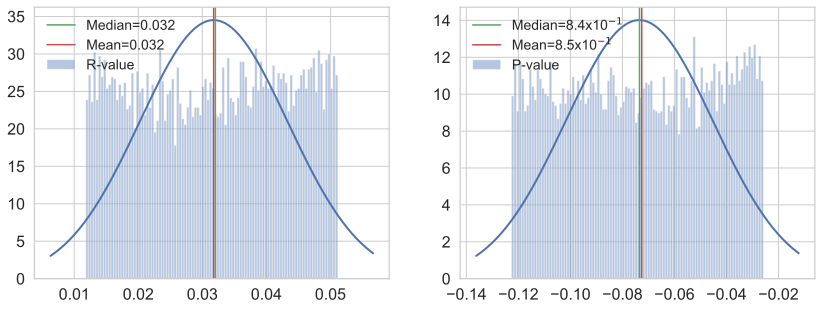

In [31]:
# load file either for small cool star as stated there or one of .pkl resulting from running MRD_adjacent_planets.py
tableEX = pandas.read_pickle("../data/lowMRT_per.pkl")

## uncomment if you want to display the sub-sample
# with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(tableEX)

counts = 10000

perrat_erD1 = numpy.zeros((len(tableEX), counts))
perrat_erD2 = numpy.zeros((len(tableEX), counts))

j = 0
for index, row in tableEX.iterrows():

    perratExo1 = []
    perratExo2 = []
    upperLimitdensity1 = (row["periodratio_error_max-1"] + row["periodratio-1"])
    lowerLimitdensity1 = (row["periodratio-1"] - abs(row["periodratio_error_min-1"]))
    # print(upperLimitdensity1, lowerLimitdensity1)
    perratExo1 = numpy.random.uniform(upperLimitdensity1, lowerLimitdensity1, counts)
    perrat_erD1[j] = perratExo1

    upperLimitdensity2 = (row["periodratio_error_max-2"] + row["periodratio-2"])
    lowerLimitdensity2 = (row["periodratio-2"] - abs(row["periodratio_error_min-2"]))
    perratExo2 = numpy.random.uniform(upperLimitdensity2, lowerLimitdensity2, counts)
    perrat_erD2[j] = perratExo2
    j +=1

pearsonmassive = []
pvaluemassive = []


for i in range(counts):
    pearson_coef = 0.
    p_value = 0.

    y1 = []
    x1 = []
    for k in range(len(tableEX)):
        y1.append(perrat_erD2[k][i])
        x1.append(perrat_erD1[k][i])
    pearson_coef, p_value = stats.pearsonr(x1, y1)

    pearsonmassive.append(pearson_coef)
    pvaluemassive.append(p_value)

fig, ax = plt.subplots(1,2,figsize=(14,5))

data = numpy.array(pearsonmassive)

seaborn.set(rc={'figure.figsize':(14,5)})

seaborn.cubehelix_palette(start=-.2,rot=.6, as_cmap=True)
seaborn.set_theme(style="whitegrid")

h = seaborn.distplot(data, hist=True, norm_hist=True, kde=False, fit=norm, fit_kws={"color": "b", "lw": 2},bins=100, hist_kws={"weights":None, "density":True, "color": "b"}, ax=ax[0], label=f"R-value")

data1 = numpy.array(pvaluemassive)

h1 = seaborn.distplot(numpy.log10(data1), hist=True, norm_hist=True, kde=False, fit=norm, fit_kws={"color": "b", "lw": 2},bins=100, hist_kws={"weights":None, "density":True, "color": "b"}, ax=ax[1], label=f"P-value")

e = data.mean()
d = numpy.log10(data1.mean())
c=numpy.median(data)
b=numpy.log10(numpy.median(data1))

ax[0].axvline(x=c,color='g', label=f"Median={format(c,'.3f')}")
ax[0].axvline(x=e,color='r', label=f"Mean={format(e,'.3f')}")

frac1, whole1 = math.modf(b)
b2 = whole1 - 1
b1 = 10 ** b * 10 ** abs(b2)
ax[1].axvline(x=b,color='g', label=f"Median={b1.round(1)}x10$^{{{round(b2)}}}$")
frac2, whole2 = math.modf(d)
d2 = whole2 - 1
d1 = 10 ** d * 10 ** abs(d2)
ax[1].axvline(x=d,color='r', label=f"Mean={d1.round(1)}x10$^{{{round(d2)}}}$")
ax[0].legend(loc="upper left", prop={"size":14}, frameon=False)
ax[1].legend(loc="upper left", prop={"size":14},frameon=False)
ax[0].tick_params(axis='both', which='major', labelsize=16)

ax[1].tick_params(axis='both', which='major', labelsize=16)

plt.savefig("Star_chunks_Pearson_dist_periodlow.png",bbox_inches="tight")
plt.savefig("Star_chunks_Pearson_dist_periodlow.svg",bbox_inches="tight")

## Sub-sample(s) and bootstrap test distribition in one graph

The bootstrap test distribution from 40 data points randomly chosen sub-samples, the median values of the Pearson coefficients for the bootstrap distribution, and the line(s) on the graph indicate the Pearson coefficients for unusually correlated sub-sample(s).

Pearson Correlation Coefficient for data:  0.04378264956897132 and a P-value of: 0.7885040412901969
R-value median for Bootstrap: -0.004360313203199084
P-value median for Bootstrap: 0.8125358882087139


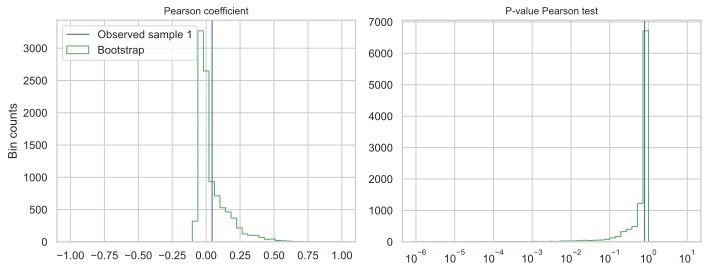

In [32]:
chunk_data = pandas.read_pickle("../data/lowMRT_per.pkl")

period_chunk1 = chunk_data["periodratio-1"]
period_chunk2 = chunk_data["periodratio-2"]

pearson_coef1, p_value1 = stats.pearsonr(period_chunk1, period_chunk2)
print("Pearson Correlation Coefficient for data: ", pearson_coef1, "and a P-value of:", p_value1)

## if you have another unusual correlated sub-sumple, uncomment below and load one of .pkl resulting from running MRD_adjacent_planets.py
# chunk_data1 = pandas.read_pickle("../data/10_0.39369665302602774_star_metallicity_periodratio.pkl") #example .pkl
# with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(chunk_data1.sort_values("star_metallicity"))
# density_chunk11 = chunk_data1["density-1"]
# density_chunk12 = chunk_data1["density-2"]
# pearson_coef2, p_value2 = stats.pearsonr(density_chunk11, density_chunk12)
# print("Pearson Correlation Coefficient for data: ", pearson_coef2, "and a P-value of:", p_value2)

Pearson = []
PvalPe = []
Spearman = []
PvalSp = []
for i in range(10000):
    pearson_coef = 0.
    p_value = 0.

    newtable =  workingTableExoplanets.sample(n=40)



    period_1 = newtable["periodratio-1"]
    period_2 = newtable["periodratio-2"]


    pearson_coef, p_value = stats.pearsonr(period_1, period_2)

    Pearson.append(pearson_coef)
    PvalPe.append(p_value)

fig, ax = plt.subplots(1, 2, figsize=(10,4))

a = numpy.linspace(-1,1,50)
c = numpy.linspace(0,1,50)

b = numpy.logspace(-6,1,50)

ax[0].hist(Pearson, bins = a, histtype='step', color='g',label="Bootstrap")
print(f"R-value median for Bootstrap: {numpy.median(Pearson)}")

ax[0].axvline(pearson_coef1,color="b", linewidth=1.1, label="Observed sample 1")
# # uncomment the line below if you have another sub-sample
# ax[0].axvline(pearson_coef2,color="orange", linewidth=1.1, label="Observed sample 2")
ax[0].set_title(r'Pearson coefficient', fontsize=10)
ax[0].set_ylabel('Bin counts')

ax[1].hist(PvalPe, bins = b, histtype='step', color='g')
print(f"P-value median for Bootstrap: {numpy.median(PvalPe)}")

ax[1].axvline(p_value1,color="b", linewidth=1.1)
# # uncomment the line below if you have another sub-sample
# ax[1].axvline(p_value2,color="orange", linewidth=1.1)

ax[1].set_title(r'P-value Pearson test', fontsize=10)
ax[1].set_xscale('log')

ax[0].legend(loc="upper left")
plt.tight_layout()
plt.savefig("rperiod_40_bootstrap_histR.png",bbox_inches="tight")
plt.savefig("rperiod_40_bootstrap_histR.svg",bbox_inches="tight")